# M2HATS Data Comparison (from Zarr)
### Purpose
Replicate a preexisting M2HATS data comparison workflow using Zarr stores, rather than individual netcdf files.

### Data
The two datasets used in this example are ERA5 reanalysis on pressure levels and 30-minute 449MHz Wind Profiler data. Both datasets have been saved as Zarr stores in Step 1 of this workflow. 

### Motivation
To assess the feasability and usability of Zarr stores in targeted analysis from an EOL field campaign.

### Audience
Any researcher or PI interested in performing analyses using EOL's in-situ data, who is looking to modernize their workflow.

---

## Import required packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

---

## Read in zarr stores

In [2]:
lustre_scratch = "/lustre/desc1/scratch/myasears"

In [4]:
era5_zarr = xr.open_zarr(f"{lustre_scratch}/2023_M2HATS/era5_M2HATS_heights.zarr")
prof449Mhz_zarr = xr.open_zarr(f"{lustre_scratch}/2023_M2HATS/prof449_M2HATS_winds30.zarr")

---

## Align datasets

#### 449 interpolation
Interpolate the 449MHz profiler dataset (referred to as "449") onto the ERA5 time grid.


In [5]:
prof449Mhz_zarr = prof449Mhz_zarr.interp(time=era5_zarr['time'])

#### ERA5 interpolation
Completed in pre-processing; the ERA5 Reanalysis Zarr store associated with this project (referred to as "ERA5") has been created using height coordinates instead of default pressure levels. 

---

## Compare datasets
Visualize and calculate the differences between ERA5 and 449 on the same height and time level for the entire M2HATS field campaign. 

### Scatter plot
This first plotting section directly compares ERA5 and 449 data points from the same time and height level, using all non-nan data from the entire field campaign. This shows us the approximate alignment of the model and profiler dataset.

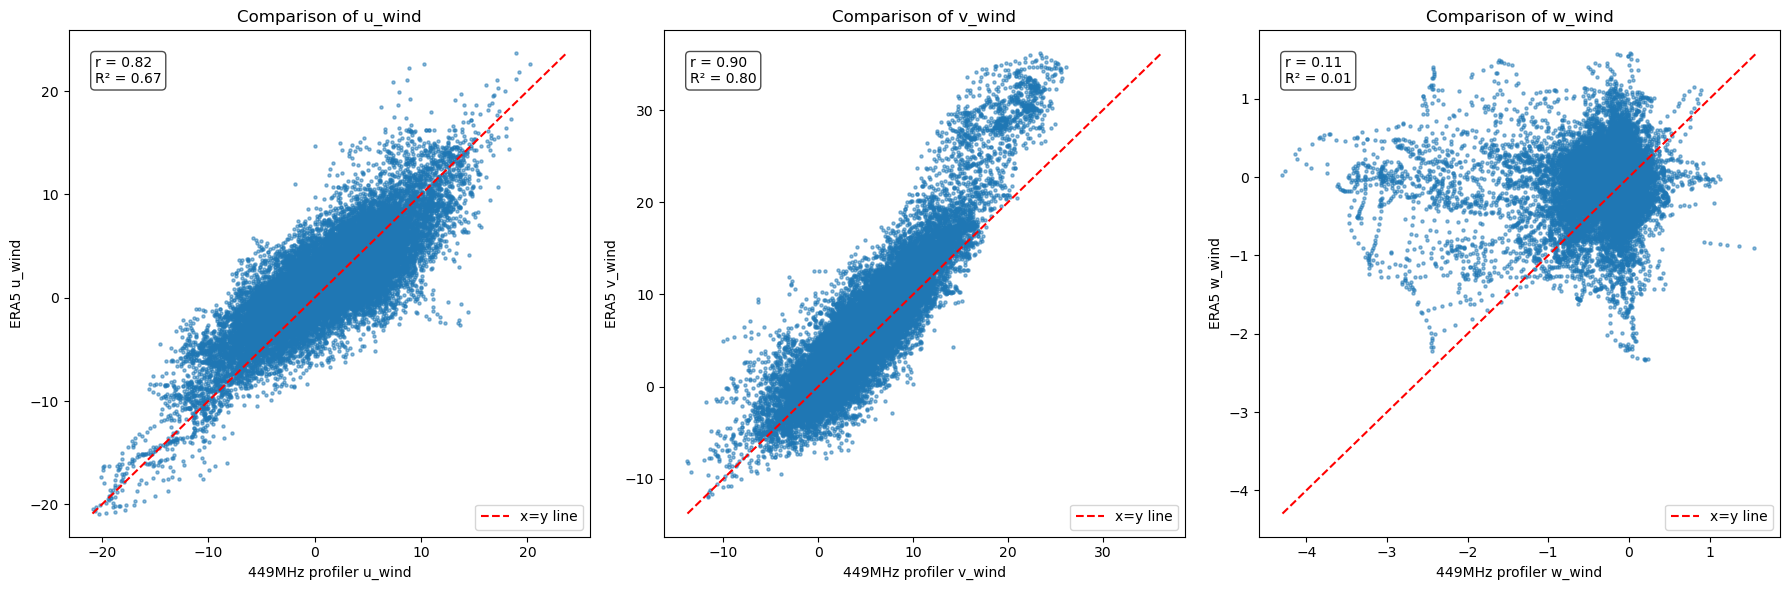

In [16]:
vars_to_compare = ["u_wind", "v_wind", "w_wind"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, var in zip(axes, vars_to_compare):
    
    # Designate x and y variables
    x = prof449Mhz_zarr[var].values.ravel()
    y = era5_zarr[var].values.ravel()

    # Mask nan values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # Scatter plot
    ax.scatter(x, y, s=5, alpha=0.5)

    # Add x = y reference line
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax.plot(lims, lims, "r--", label="x=y line")

    # Correlation and R²
    r = np.corrcoef(x, y)[0, 1]
    r2 = r ** 2
    ax.text(
        0.05, 0.95,
        f"r = {r:.2f}\nR² = {r2:.2f}",
        transform=ax.transAxes,
        va="top", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
    )

    ax.set_xlabel(f"449MHz profiler {var}")
    ax.set_ylabel(f"ERA5 {var}")
    ax.set_title(f"Comparison of {var}")
    ax.legend()

plt.tight_layout()
plt.show()

**Horizontal winds:**       
From this visual comparison, it's clear that u winds and v winds are generally comparable between the ERA5 model and 449 data, as the scatter points approximately follow the x=y line. Additionally, the R^2 values are sufficiently high enough that we suspect that ERA5 will be a good comparison tool for many weather scenarios during this campaign; we will look into specific points of divergence in the next step.       

**Vertical winds:**       
Both the shape of the w winds plot and its associated R^2 values indicate significant differences between observed and modeled data for this field campaign. We will attempt to identify specific points of divergence during the next step, which might allow us to find scenarios where the ERA5 model and the 449 data agree. 
       
Also worth noting: this notebook only provides a case study between two sources. If we were performing a full field campaign analysis, we would bring in an additional 4+ data sources to further understand the source of the differences seen between ERA5 and 449 vertical winds.

### Attribution plot
This second section attempts to understand where the differences between ERA5 and 449 data points arise, exploring the (averaged) mean absolute error (MAE) between the two aligned datasets on: each day of the field campaign, each hour of the day, and each height level. The division of MAE between these variables allows us to identify any consistent or anomalous errors.        

**For example:** the daily MAE plot can indicate specific high-error days, such as a hurricane passage, that caused error rates to spike. The hourly MAE plot can suggest times of day where error is anomalously high, such as during the night. The height levels MAE can allude to errors in space, such as a disagreement between surface wind magnitudes. 

/glade/derecho/scratch/myasears/tmp/ipykernel_49461/3889417139.py:28: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(error, axis=0)


day
2023-07-11         NaN
2023-07-12         NaN
2023-07-13    0.731974
2023-07-14    0.441515
2023-07-15    1.002371
2023-07-16    3.371845
2023-07-17    1.867796
2023-07-18    1.944614
2023-07-19    1.749820
2023-07-20    2.005526
2023-07-21    1.417821
2023-07-22    1.863199
2023-07-23    1.565970
2023-07-24    2.715056
2023-07-25    2.150445
2023-07-26    2.233587
2023-07-27    2.576637
2023-07-28    2.529628
2023-07-29    2.058770
2023-07-30    2.446019
2023-07-31    2.028839
2023-08-01    1.639831
2023-08-02    2.149127
2023-08-03    2.316288
2023-08-04    1.653940
2023-08-05    2.220151
2023-08-06    1.829239
2023-08-07    1.805017
2023-08-08    2.076965
2023-08-09    1.793462
2023-08-10    2.065139
2023-08-11    1.383275
2023-08-12    1.840831
2023-08-13    2.784710
2023-08-14    1.332891
2023-08-15    1.675666
2023-08-16    1.643636
2023-08-17    2.142914
2023-08-18    2.839432
2023-08-19    1.948896
2023-08-20    5.485281
2023-08-21    6.101576
2023-08-22    1.926730
2023-08

/glade/derecho/scratch/myasears/tmp/ipykernel_49461/3889417139.py:28: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(error, axis=0)


day
2023-07-11          NaN
2023-07-12          NaN
2023-07-13    71.861269
2023-07-14    86.492246
2023-07-15    63.873761
2023-07-16    67.883531
2023-07-17    21.673739
2023-07-18    26.153044
2023-07-19    46.194817
2023-07-20    46.588400
2023-07-21    54.521226
2023-07-22    36.992958
2023-07-23    20.876646
2023-07-24    33.736256
2023-07-25    19.142566
2023-07-26    20.047999
2023-07-27    19.298388
2023-07-28    33.226873
2023-07-29    20.641361
2023-07-30    37.088827
2023-07-31    34.102363
2023-08-01    31.369067
2023-08-02    45.207505
2023-08-03    28.256299
2023-08-04    26.198529
2023-08-05    36.553171
2023-08-06    57.484264
2023-08-07    32.059819
2023-08-08    23.643438
2023-08-09    24.197842
2023-08-10    26.930087
2023-08-11    25.156274
2023-08-12    36.233392
2023-08-13    74.450810
2023-08-14    35.056680
2023-08-15    40.808836
2023-08-16    95.952696
2023-08-17    42.927584
2023-08-18    14.552635
2023-08-19    22.554152
2023-08-20    24.658534
2023-08-21  

/glade/derecho/scratch/myasears/tmp/ipykernel_49461/3889417139.py:28: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(error, axis=0)


day
2023-07-11         NaN
2023-07-12         NaN
2023-07-13    0.333394
2023-07-14    0.503800
2023-07-15    0.152713
2023-07-16    0.528365
2023-07-17    0.323722
2023-07-18    0.346172
2023-07-19    0.394709
2023-07-20    0.677707
2023-07-21    0.377343
2023-07-22    0.387054
2023-07-23    0.326678
2023-07-24    0.620204
2023-07-25    0.687062
2023-07-26    0.212837
2023-07-27    0.436109
2023-07-28    0.448118
2023-07-29    0.259518
2023-07-30    0.419303
2023-07-31    0.296643
2023-08-01    0.362342
2023-08-02    0.555321
2023-08-03    0.451475
2023-08-04    0.446601
2023-08-05    0.463258
2023-08-06    0.460357
2023-08-07    0.444043
2023-08-08    0.378418
2023-08-09    0.339128
2023-08-10    0.334547
2023-08-11    0.336583
2023-08-12    0.291453
2023-08-13    0.674190
2023-08-14    0.249474
2023-08-15    0.388333
2023-08-16    0.387046
2023-08-17    0.303540
2023-08-18    0.379481
2023-08-19    0.268476
2023-08-20    1.029598
2023-08-21    0.661625
2023-08-22    0.188062
2023-08

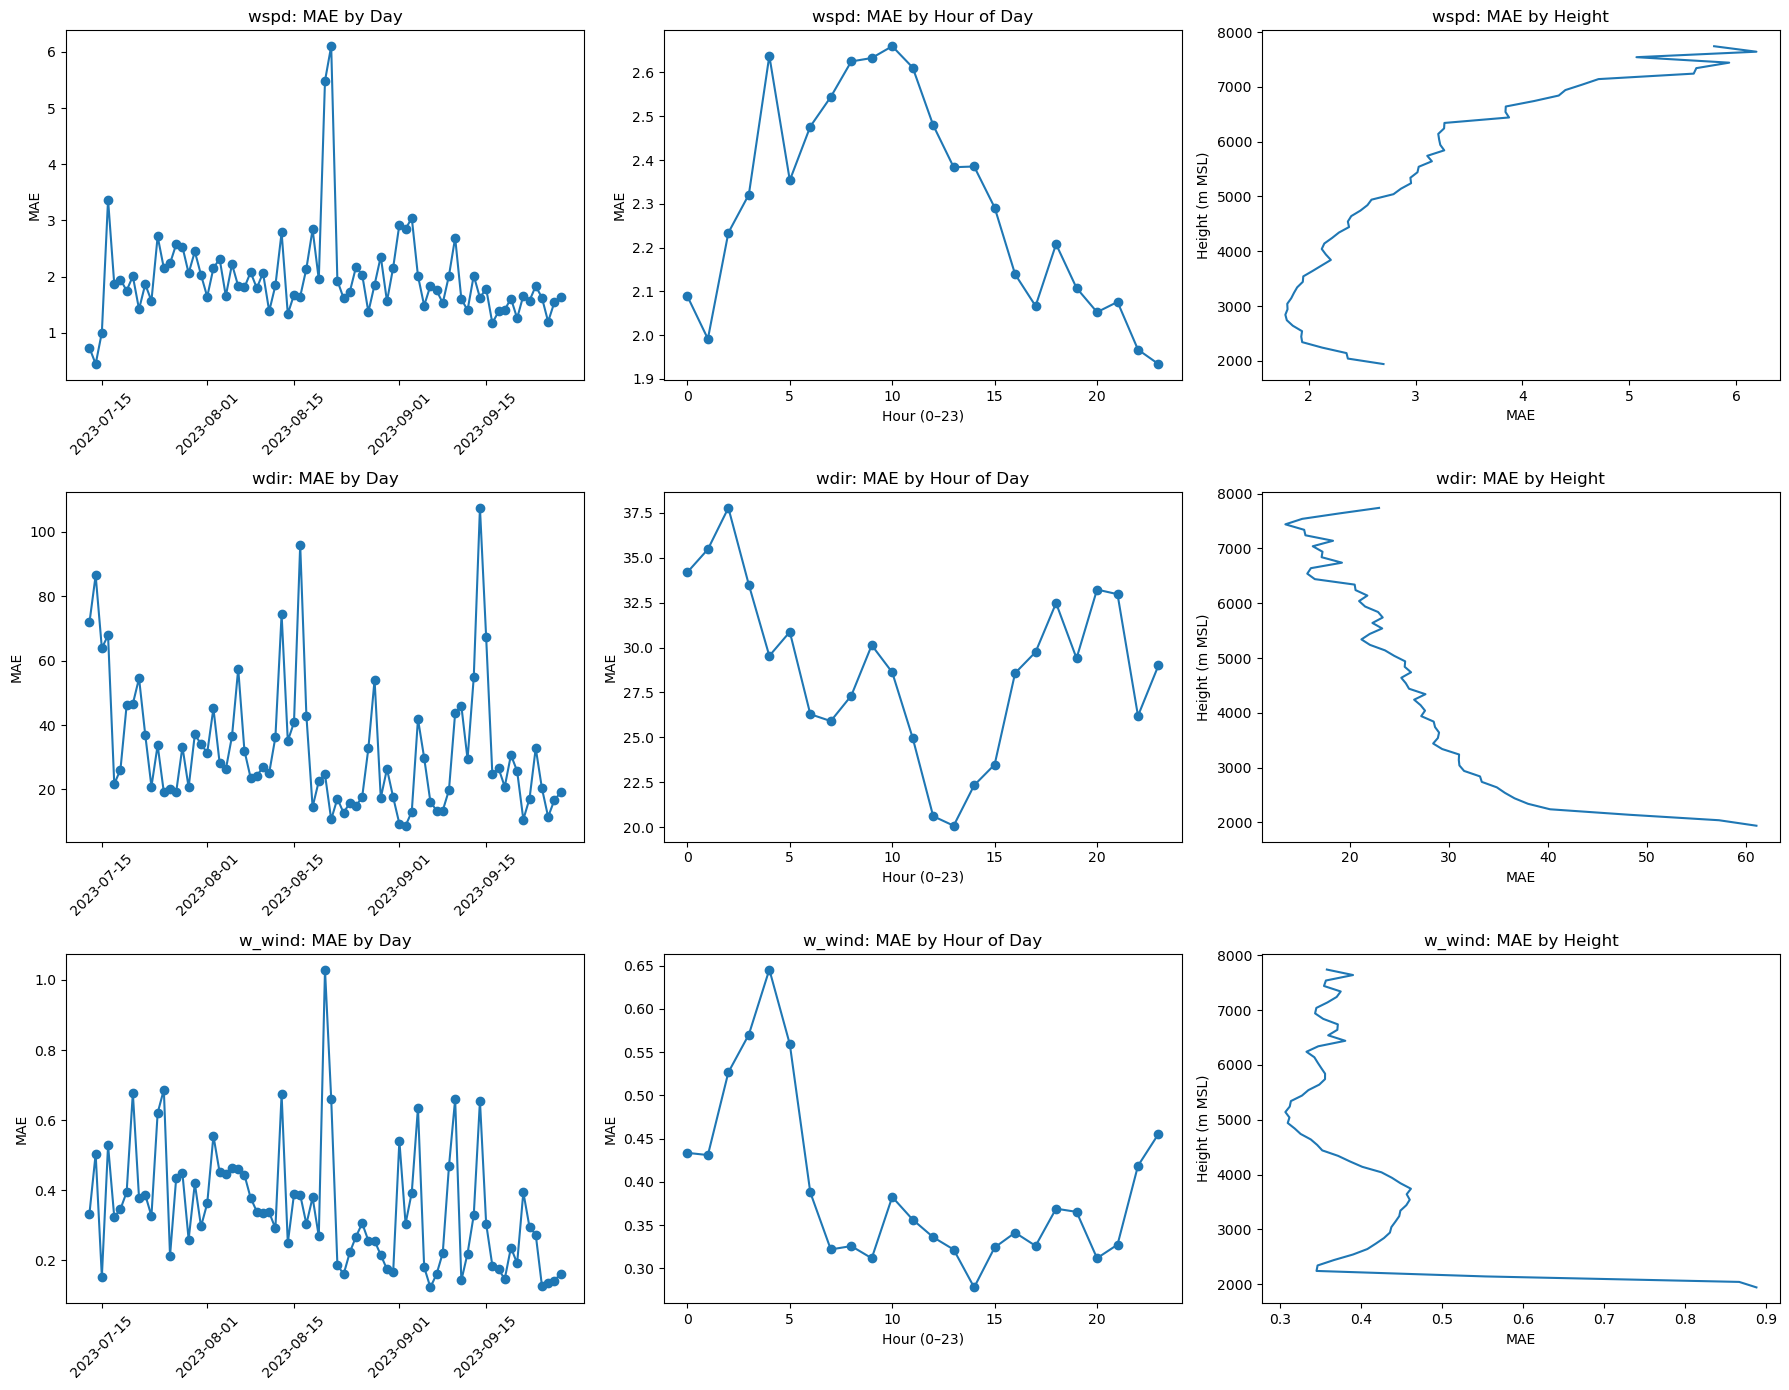

In [27]:
vars_to_compare = ["wspd", "wdir", "w_wind"]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))

for row, var in enumerate(vars_to_compare):

    # Extract variable arrays
    prof449 = prof449Mhz_zarr[var].values
    era5    = era5_zarr[var].values
    time    = prof449Mhz_zarr["time"].values
    height  = prof449Mhz_zarr["height_msl"].values

    # Calculate absolute error
    error = np.abs(prof449 - era5)

    # --- Daily MAE ---
    df_daily = pd.DataFrame({
        "time": np.repeat(time, len(height)),
        "error": error.reshape(len(time) * len(height))})

    df_daily["day"] = pd.to_datetime(df_daily["time"]).dt.date
    mae_daily = df_daily.groupby("day")["error"].mean()

    # --- Hourly MAE ---
    df_daily["hour"] = pd.to_datetime(df_daily["time"]).dt.hour
    mae_hourly = df_daily.groupby("hour")["error"].mean()

    # --- Height MAE ---
    mae_height = np.nanmean(error, axis=0)

    # Plot the comparisons
    ax = axes[row, 0]
    ax.plot(mae_daily.index, mae_daily.values, marker="o")
    ax.set_title(f"{var}: MAE by Day")
    ax.set_ylabel("MAE")
    ax.tick_params(axis="x", rotation=45)

    ax = axes[row, 1]
    ax.plot(mae_hourly.index, mae_hourly.values, marker="o")
    ax.set_title(f"{var}: MAE by Hour of Day")
    ax.set_xlabel("Hour (0–23)")
    ax.set_ylabel("MAE")

    ax = axes[row, 2]
    ax.plot(mae_height, height)
    ax.set_title(f"{var}: MAE by Height")
    ax.set_xlabel("MAE")
    ax.set_ylabel("Height (m MSL)")

plt.tight_layout()
plt.show()

**Wind Speed MAE:**
- By day: We see that the daily average wind speed MAE ranges from 1-3 m/s, with two notable outliers. These outliers occur on 8/20/2023 (5.485281 m/s) and 8/21/2023 (6.101576 m/s) and coencide with the passage of [Hurricane Hilary](https://www.nhc.noaa.gov/data/tcr/EP092023_Hilary.pdf) over the region, and its corresponding high wind speeds. With the consistency of the other, more mild, days, we notice that the sources diverge on high wind days. The addition of other instruments can lend insight into which source is having difficulty measuring or representing high winds. 
- By hour: There is certainly a diurnal pattern in the comparison of wind speed MAE by hour of day. The greatest divergences occur around 10Z (3am local time), and the largest agreement is found around 23Z (4pm local time).       
- By height: It can be clearly seen that the instruments disagree much more with height. The greatest agreeance is found from around 2100-3900 meters above mean sea level (around 500-2300 meters AGL). Above 6000 meters, we see greatly increasing MAE between the sources.

**Wind Direction MAE:**

**Vertical Wind MAE:**